In [ ]:
import numpy as np 
import tensorflow as tf
import os 
import sys 

import shap
def compute_data_metrics(classifier, input_data, input_adj, y_true):
    # Assuming the TensorFlow  is stored in the variable `model`
    y_train_pred = classifier.model.predict([input_data, input_adj])
    y_train_pred_argmax = np.argmax(y_train_pred, axis=1)
    y_train_true = np.argmax(y_true, axis=1)
    from utils.utils_mine import get_metrics
    return get_metrics(y_train_pred_argmax, y_train_true)

main_pth = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/'
sys.path.append(main_pth)
os.chdir(main_pth)
from LOO_nested_CV_model import build_model


model_name = 'gnn_transformer_with_cli_demo' # 'gnn_transformer'
config_file_name = 'pretreatment_response_cv_5_mix_hb'
msg = 'loocv_v4to13'
TrainModel = build_model(model_name, config_file_name, msg)


In [2]:
from utils.utils_mine import stratified_LOO_nested_CV

data = TrainModel.data
label = TrainModel.label
adj = TrainModel.adj
if TrainModel.cli_demo.any():
    cli_demo = TrainModel.cli_demo
else:
    cli_demo = None
current_loo = 0
k = 0
num_of_k_fold = 5
classifier = TrainModel.model
X_train, Y_train, X_val, Y_val, X_test, Y_test, adj_train, adj_val, adj_test = stratified_LOO_nested_CV(data, label, k=k, num_of_k_fold=num_of_k_fold, current_loo=current_loo, adj=adj)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

train_index tf.Tensor(
[22 25 26 38 39 41 45 47 48 55 56 60 10 11 12 13 15 16 17 18 19 21 23 24
 27 28 29 30 31 32 33 34 35 36 37 40 42 43 44 46 49 50 51 52 53 54 57 58
 59 61 62 63], shape=(52,), dtype=int32)
X_train: (52, 52, 2500)
X_val: (11, 52, 2500)
X_test: (1, 52, 2500)


In [ ]:
from utils.fnirs_utils import get_metrics_auc

all_subjects_shap = []
val_metrics = []
test_metrics = []
y_pred_test_all = []
y_pred_val_all = []

for v_i in range(4, 4+10):
    model_para = f'loocv_v{v_i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6'
    y_pred_test_fold = []
    for subject in range(64):
        for k_fold in range(num_of_k_fold):
            X_train, Y_train, X_val, Y_val, X_test, Y_test, adj_train, adj_val, adj_test = stratified_LOO_nested_CV(data, label, k=k_fold, num_of_k_fold=num_of_k_fold, current_loo=subject, adj=adj)
            checkpoint_path = f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/{model_para}/LOO_nested_CV/LOO_{subject}/stratified_nested_5_CV_fold-{k_fold}/fold-best-checkpoint'

            classifier.model.load_weights(checkpoint_path)
            model = classifier.model
            y_pred_val = model.predict([X_val, adj_val])
            y_pred_test = model.predict([X_test, adj_test])
            y_pred_test_fold.append(y_pred_test)
            val_metrics.append(get_metrics_auc(Y_val.argmax(axis=1), y_pred_val))
    y_pred_test_fold = np.array(y_pred_test_fold)
    y_pred_test_fold = np.squeeze(y_pred_test_fold)
    y_pred_test_fold = y_pred_test_fold.reshape(64, 5, 2)
    y_pred_test_fold = np.mean(y_pred_test_fold, axis=1)
    y_pred_test_all.append(y_pred_test_fold)
    test_metrics.append(get_metrics_auc(y_pred_test_fold.argmax(axis=1), label))
            # NOTE TO DO: why the train metrics are very bad? see sub-0 fold-0/1 
            # train_metrics = compute_data_metrics(classifier, X_train, adj_train, Y_train)
            # val_metrics = compute_data_metrics(classifier, X_val, adj_val, Y_val)
            # print(f"sub - {subject} - fold - {k_fold} - train metrics - {train_metrics}")
            # print(f"sub - {subject} - fold - {k_fold} - val metrics - {val_metrics}")
            
            # explainer = shap.GradientExplainer(classifier.model, [X_train, adj_train])
            # shap_values, _ = explainer.shap_values([X_test, adj_test])
            # all_subjects_shap.append(shap_values)


In [ ]:

from utils.fnirs_utils import get_metrics_auc

all_subjects_shap = []
val_metrics = []
test_metrics = []
y_pred_test_all = []
y_pred_val_all = []
for v_i in range(10, 20):
    model_para = f'loocv_v{v_i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6'
    y_pred_test_fold = []
    for subject in range(64):
        for k_fold in range(num_of_k_fold):
            X_train, Y_train, X_val, Y_val, X_test, Y_test, adj_train, adj_val, adj_test, cli_demo_train, cli_demo_val, cli_demo_test = stratified_LOO_nested_CV(data, label, k=k_fold, num_of_k_fold=num_of_k_fold, current_loo=subject, adj=adj, cli_demo=cli_demo)
            checkpoint_path = f'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/{model_para}/LOO_nested_CV/LOO_{subject}/stratified_nested_5_CV_fold-{k_fold}/fold-best-checkpoint'

            classifier.model.load_weights(checkpoint_path)
            model = classifier.model
            y_pred_val = model.predict([X_val, adj_val, cli_demo_val])
            y_pred_test = model.predict([X_test, adj_test, cli_demo_test])
            y_pred_test_fold.append(y_pred_test)
            val_metrics.append(get_metrics_auc(Y_val.argmax(axis=1), y_pred_val))
    y_pred_test_fold = np.array(y_pred_test_fold)
    y_pred_test_fold = np.squeeze(y_pred_test_fold)
    y_pred_test_fold = y_pred_test_fold.reshape(64, 5, 2)
    y_pred_test_fold = np.mean(y_pred_test_fold, axis=1)
    y_pred_test_all.append(y_pred_test_fold)
    test_metrics.append(get_metrics_auc(y_pred_test_fold.argmax(axis=1), label))
            # NOTE TO DO: why the train metrics are very bad? see sub-0 fold-0/1 
            # train_metrics = compute_data_metrics(classifier, X_train, adj_train, Y_train)
            # val_metrics = compute_data_metrics(classifier, X_val, adj_val, Y_val)
            # print(f"sub - {subject} - fold - {k_fold} - train metrics - {train_metrics}")
            # print(f"sub - {subject} - fold - {k_fold} - val metrics - {val_metrics}")
            
            # explainer = shap.GradientExplainer(classifier.model, [X_train, adj_train])
            # shap_values, _ = explainer.shap_values([X_test, adj_test])
            # all_subjects_shap.append(shap_values)


In [4]:
np_test_metrics = np.array(test_metrics)
np_test_metrics[:, 0] = (np_test_metrics[:, 1] + np_test_metrics[:, 0]) / 2
print(np_test_metrics)

[[0.5671875  0.4        0.83673469 0.61836735]
 [0.546875   0.375      0.83333333 0.60416667]
 [0.61358173 0.46153846 0.84313725 0.65233786]
 [0.58928571 0.42857143 0.84       0.63428571]
 [0.51041667 0.33333333 0.82608696 0.57971014]
 [0.57306985 0.41176471 0.85106383 0.63141427]
 [0.52803309 0.35294118 0.82978723 0.59136421]
 [0.61614583 0.46666667 0.85714286 0.66190476]
 [0.640625   0.5        0.84615385 0.67307692]
 [0.546875   0.375      0.83333333 0.60416667]]


In [5]:
np_val_metrics = np.array(val_metrics)
np_val_metrics = np.reshape(np_val_metrics, (-1, 64, 5, 4))
np_val_metrics = np.mean(np_val_metrics, axis=(1,2))
np_val_metrics[:, 0] = (np_val_metrics[:, 1] + np_val_metrics[:, 2])/2
print(np_val_metrics.shape)
print(np_val_metrics)

(10, 4)
[[0.75776042 0.590625   0.92489583 0.69565972]
 [0.75340278 0.584375   0.92243056 0.69706597]
 [0.75293403 0.578125   0.92774306 0.70366319]
 [0.75595486 0.590625   0.92128472 0.71010417]
 [0.76105903 0.596875   0.92524306 0.71980903]
 [0.7490625  0.5671875  0.9309375  0.69829861]
 [0.75142361 0.571875   0.93097222 0.71489583]
 [0.75829861 0.5859375  0.93065972 0.70935764]
 [0.75923611 0.59375    0.92472222 0.72203125]
 [0.74357639 0.55625    0.93090278 0.70305556]]


In [6]:
np_y_pred_test_all = np.array(y_pred_test_all)
print(np_y_pred_test_all.shape)

(10, 64, 2)


In [8]:
save_fold = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten-fold-evaluate'
np.save(save_fold + '/val_metrics.npy', np_val_metrics)
np.save(save_fold + '/test_metrics.npy', np_test_metrics)
np.save(save_fold + '/y_pred_test_all.npy', np_y_pred_test_all)

In [11]:
save_fold = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten-fold-evaluate'
reload_test_metrics = np.load(save_fold + '/test_metrics.npy')
reload_val_metrics = np.load(save_fold + '/val_metrics.npy')
reload_y_pred_test_all = np.load(save_fold + '/y_pred_test_all.npy')
print(reload_test_metrics)
print('-'*10)
print(reload_val_metrics)


[[0.69196429 0.57142857 0.88       0.72571429]
 [0.69791667 0.58333333 0.86538462 0.72435897]
 [0.75520833 0.66666667 0.88461538 0.77564103]
 [0.66766827 0.53846154 0.8627451  0.70060332]
 [0.69791667 0.58333333 0.86538462 0.72435897]
 [0.73224432 0.63636364 0.86792453 0.75214408]
 [0.75520833 0.66666667 0.88461538 0.77564103]
 [0.79332386 0.72727273 0.88679245 0.80703259]
 [0.79332386 0.72727273 0.88679245 0.80703259]
 [0.73224432 0.63636364 0.86792453 0.75214408]]
----------
[[0.76895833 0.6046875  0.93322917 0.70652778]
 [0.76142361 0.584375   0.93847222 0.70818576]
 [0.76402778 0.5984375  0.92961806 0.70546875]
 [0.75852431 0.584375   0.93267361 0.6946875 ]
 [0.74736111 0.55625    0.93847222 0.69571181]
 [0.76064236 0.5859375  0.93534722 0.69776042]
 [0.76496528 0.5984375  0.93149306 0.71104167]
 [0.76307292 0.5890625  0.93708333 0.69505208]
 [0.75241319 0.575      0.92982639 0.70423611]
 [0.75854167 0.58125    0.93583333 0.69467014]]


In [12]:

def print_test_val_metrics(np_test_metrics, np_val_metrics):
    mean_test_metrics = np.mean(np_test_metrics, axis=0)
    std_test_metrics = np.std(np_test_metrics, axis=0)

    mean_val_metrics = np.mean(np_val_metrics, axis=0)
    std_val_metrics = np.std(np_val_metrics, axis=0)

    from utils.fnirs_utils import print_md_table_val_test_AUC
    print_md_table_val_test_AUC('Mean', mean_test_metrics, mean_val_metrics, already_balanced_accuracy=True)
    print_md_table_val_test_AUC('STD', std_test_metrics, std_val_metrics, already_balanced_accuracy=True, print_table_header=False)
print_test_val_metrics(reload_test_metrics, reload_val_metrics)


| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| Mean   | 73.1702  | 63.3716  | 87.5218  | 75.4467  | 75.9993  | 58.5781  | 93.4205  | 70.1334  |
| STD   | 4.0820  | 6.1418  | 0.9606  | 3.4605  | 0.5955  | 1.3044  | 0.3155  | 0.6051  |


In [4]:
all_subjects_shap = np.array(all_subjects_shap)
print(all_subjects_shap.shape)
np.save('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap.npy', all_subjects_shap)



(0,)


In [5]:
for v_i in range(5, 14):
    model_para = f'loocv_v{v_i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6'
    all_subjects_shap_test = []
    all_subjects_shap_val = []
    for subject in range(64):
        for k_fold in range(num_of_k_fold):
            X_train, Y_train, X_val, Y_val, X_test, Y_test, adj_train, adj_val, adj_test = stratified_LOO_nested_CV(data, label, k=k_fold, num_of_k_fold=num_of_k_fold, current_loo=subject, adj=adj)
            X_train = X_train[..., np.newaxis]
            X_test = X_test[..., np.newaxis]
            X_val = X_val[..., np.newaxis]
            # checkpoint_path = f'results/gnn_transformer/prognosis/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_{subject}/stratified_nested_5_CV_fold-{k_fold}/fold-best-checkpoint'
            checkpoint_path = f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/{model_para}/LOO_nested_CV/LOO_{subject}/stratified_nested_5_CV_fold-{k_fold}/fold-best-checkpoint'
            classifier.model.load_weights(checkpoint_path)

            
            # NOTE TO DO: why the train metrics are very bad? see sub-0 fold-0/1 
            # train_metrics = compute_data_metrics(classifier, X_train, adj_train, Y_train)
            # val_metrics = compute_data_metrics(classifier, X_val, adj_val, Y_val)
            # print(f"sub - {subject} - fold - {k_fold} - train metrics - {train_metrics}")
            # print(f"sub - {subject} - fold - {k_fold} - val metrics - {val_metrics}")
            
            
            
            explainer = shap.GradientExplainer(classifier.model, [X_train, adj_train])
            shap_values_test, _ = explainer.shap_values([X_test, adj_test])
            shap_values_val, _ = explainer.shap_values([X_val, adj_val])
            all_subjects_shap_test.append(shap_values_test)
            all_subjects_shap_val.append(shap_values_val)
    np.save(f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/{model_para}/LOO_nested_CV/shap_test.npy', all_subjects_shap_test)
    np.save(f'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/{model_para}/LOO_nested_CV/shap_val.npy', all_subjects_shap_val)


/home/jy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [22]:
all_shap = np.concatenate((shap_52, shap_last_12), axis=0)

In [20]:
shap_values_v1 = all_shap.copy()
print(shap_values_v1.shape)

shap_values_v1 = np.squeeze(shap_values_v1)
shap_values_v1 = np.mean(shap_values_v1, axis=0)[..., 1]
print(shap_values_v1.shape)


(320, 1, 52, 2500, 1, 2)
(52, 2500)


<BarContainer object of 52 artists>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

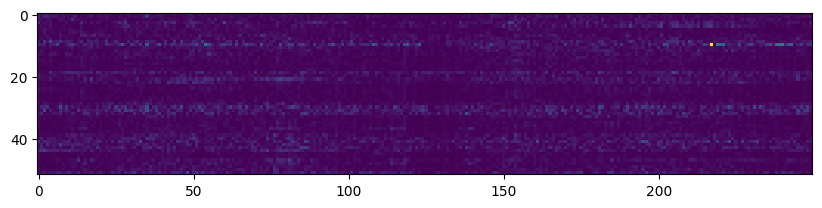

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

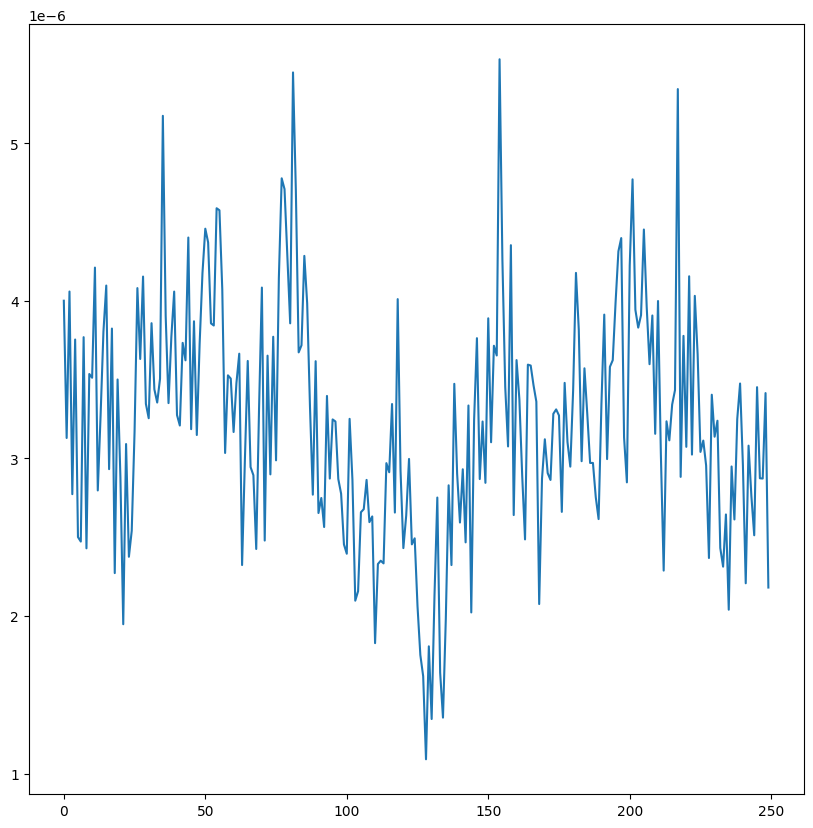

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

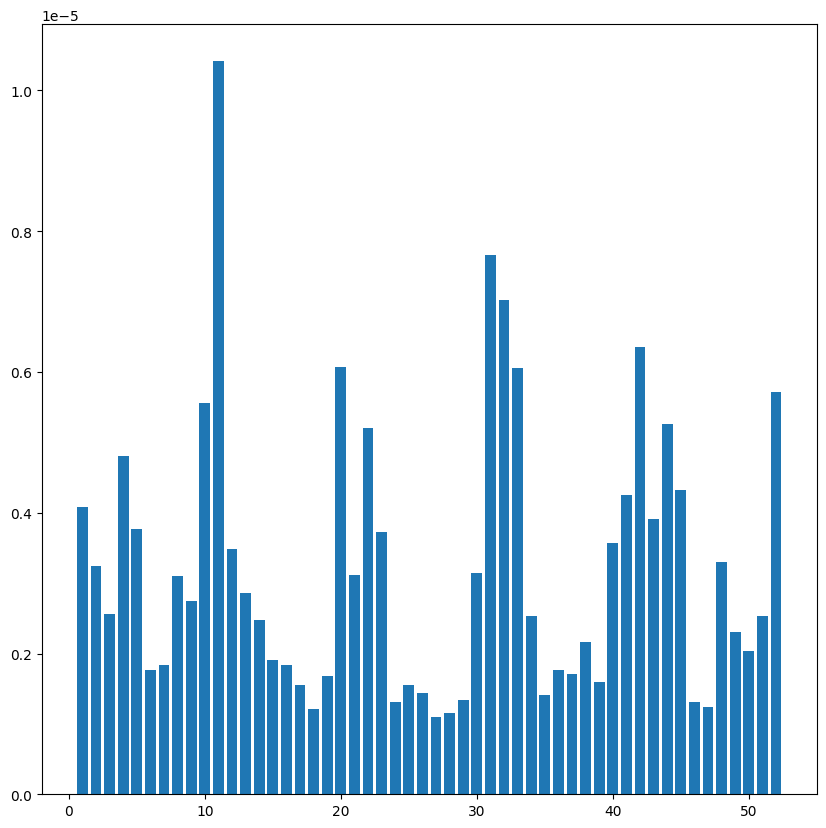

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
val = shap_values_v1.copy()

val = val.reshape(52, 250,10)
val = np.mean(val, axis=2)
val = np.abs(val)

# plot the SHAP values
plt.figure(figsize=(10, 10))
plt.imshow(val, cmap='viridis')


mean_0_val = np.mean(val, axis=0)
plt.figure(figsize=(10, 10))
plt.plot(mean_0_val)



mean_1_val = np.mean(val, axis=1)
plt.figure(figsize=(10, 10))
plt.bar(np.arange(1,53),mean_1_val)

In [17]:
np.array(tmp).shape


shap_52 = np.array(tmp).copy()

In [13]:
np.save('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v2l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/shap_0-52.npy', np.array(tmp))